<h1 style="text-align: center;">Natural Language Proceswing: News Classifier</h1>

<br>
<div style="display:inline;"> By:
<ul style="display: inline;">
<li style="display: inline;"><a href="https://github.com/am2en" target="_blank">Ameen Taha</a></li>
, <li style="display: inline;"><a href="https://github.com/saebghazal" target="_blank">Saeb Ghazal</a></li>
, <li style="display: inline;"><a href="https://github.com/ramiazmi" target="_blank">Rami Tailakh</a></li>
</ul>
</div>


## Introduction:
In the past few years, data has been increased dramatically. Majority of data is unstructured, and text data is viewed as unstructured as well; from the computer perspective. That is, text data is (a large volume) set words, and these words contain alphabetical letters, numbers and special characters, in addition, it can contain both single-byte and multi-byte characters. As a result, text analysis is one of the important applications for many businesses and organizations, nowadays. 

Text data is employed in many domains; social media, news stories, customer reviews, emails, documents and many more. However, this type of data can be difficult to analyze. This is because each text is witten in a specific language, thereby, analyzing a text could differ from one language to another. Moreover, A word in a specific language can give different meanings, and more challenging, languages adapt according to cultures and there could be some differences in using and writing words from one geographic area to another for the same language.

Natural Language Processing (NLP) is the field of study that is concerned with the interactions between human language and computing machine. NLP, in other words, NLP is to enable a computerized program to understand human language to an accepted level. In this piece of work, we will apply NLP techniques on news stories aiming to classify the category of news articles.  



# Goal:
In this project, we will employ some machine learning models in order to build a classifier for news stories. The job of this classifier specifically is to predict the category (health, technology, etc.) of a news story given only its titele.

In [99]:
# This code is to disable warnings that may display this notebook a liitle bit "ugly"
import warnings
warnings.filterwarnings('ignore')

# Imports
Here, all required packages in this project will be imported.

In [100]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lime

from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, KFold, train_test_split

from sklearn.pipeline import Pipeline

from nltk.corpus import stopwords

import string

from sklearn.learning_curve import learning_curve

from ipywidgets import widgets
from IPython.display import display
from IPython.display import clear_output

from collections import Counter

import pickle

import sys

%matplotlib inline

# Dataset:
We will use the [News Data Set from Kaggle](https://www.kaggle.com/uciml/news-aggregator-dataset).
This dataset contains headlines, publishers, URLs, and categories for 422,937 news articles. News categories included in this dataset include business; science and technology; entertainment; and health. 

### Get the Data

The next code is to read the uci-news-aggregator.csv file and set it as a dataframe called news.

In [101]:
news = pd.read_csv('uci-news-aggregator.csv')
news=news.sample(n=1000)

### Helper Functions
These are the functions that will be used in this project.

In [105]:
def count_words(str):
    '''
    This function is count the number of words in a given text.
    '''
    return len(str.split())

In [106]:
def text_process(mess):
    """
    This function takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    stop_words = set(stopwords.words('english'))
    stop_words.update(['2014', 'us','new','may']) # remove it if you need punctuation 

    return ' '.join(word for word in nopunc.split() if word.lower() not in stop_words)

In [104]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    This function is to generate a simple plot of the test and traning learning curve.
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [107]:
def normalize_text(p_message):
    '''
    This function will remove all stop words from a given text.
    '''
    nopunc = [char for char in p_message if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return ''.join(word.lower() for word in nopunc.split() if word not in stopwords.words('english'))  

In [108]:
def class_desc(p_class):
    '''
    This function is to return the description of CATEGORY.
    '''
    if p_class == 'b':
        str = 'Business'
    elif p_class == 't':
        str = 'Science and Technology'
    elif p_class == 'e':
        str = 'Entertainment'
    elif p_class == 'm':
        str = 'Health'
    else:
        p_class = ''
    
    return str

In [109]:
def read_from_pickle(pickle_fname):
    with open(pickle_fname+'.pickle', 'rb') as handle:
        return pickle.load(handle)

# EDA
In this section, we are going to view the dataset structure and do some exploration analysis on the data.

In [110]:
news.head(2)

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
122981,123317,"Miley Cyrus hospitalised, cancels US concert",http://www.dawn.com/news/1100267/miley-cyrus-h...,DAWN.com,e,dDmxjpepfUL3XqMCmVlc0Xes8SZjM,www.dawn.com,1397653320501
255973,256419,Zuckerberg summoned by Iran court,http://www.thedailystar.net/world/zuckerberg-s...,The Daily Star,t,dqeG4PzlulOu82MBBaziYnMHlIggM,www.thedailystar.net,1401228998103


In [111]:
news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 122981 to 206528
Data columns (total 8 columns):
ID           1000 non-null int64
TITLE        1000 non-null object
URL          1000 non-null object
PUBLISHER    1000 non-null object
CATEGORY     1000 non-null object
STORY        1000 non-null object
HOSTNAME     1000 non-null object
TIMESTAMP    1000 non-null int64
dtypes: int64(2), object(6)
memory usage: 70.3+ KB


In [112]:
news.describe()

,ID,TIMESTAMP
count,1000.000000,1.000000e+03
mean,213209.834000,1.400489e+12
std,121758.649622,3.719903e+09
min,582.000000,1.394485e+12
25%,108433.750000,1.397404e+12
50%,214700.000000,1.400391e+12
75%,320667.250000,1.403801e+12
max,422567.000000,1.409226e+12


**Data Preprocessing**

We are going to create a new column called <b>TITLE_LENGTH</b> which represents the number of words in the <b>TITLE</b> column which represents an article headline. This will, then, help do some EDA analytics.

In [113]:
news['TITLE_LENGTH'] = news['TITLE'].apply(count_words)

**Data Exploration**

The following plot is to show the number of articles per each <b>CATEGORY</b>.

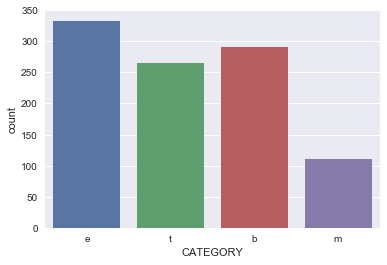

In [114]:
sns.countplot(x="CATEGORY", data=news)

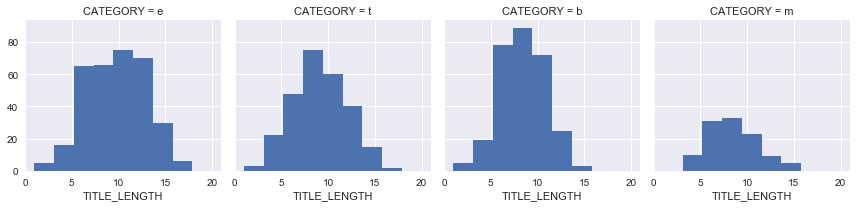

In [115]:
g = sns.FacetGrid(news, col="CATEGORY", sharey=True)  
g.map(plt.hist, "TITLE_LENGTH", bins=np.linspace(1, 20, 10))

The following is to plot a boxplot to show the distribution of word counts (using <b>TITLE_LENGTH</b> column) per each <b>CATEGORY<b>.

(0, 30)

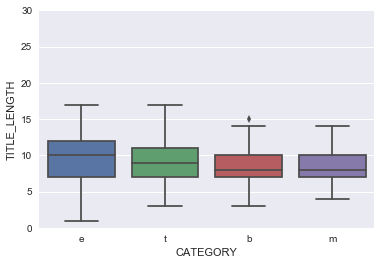

In [116]:
_= sns.boxplot(x='CATEGORY', y='TITLE_LENGTH', data = news)
_.set_ylim(0,30)

The following plot is to display the histogram according to the <b>TITLE</b> words count per each <b>CATEGORY</b>.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001DBD21D0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000001C80E748>]], dtype=object)

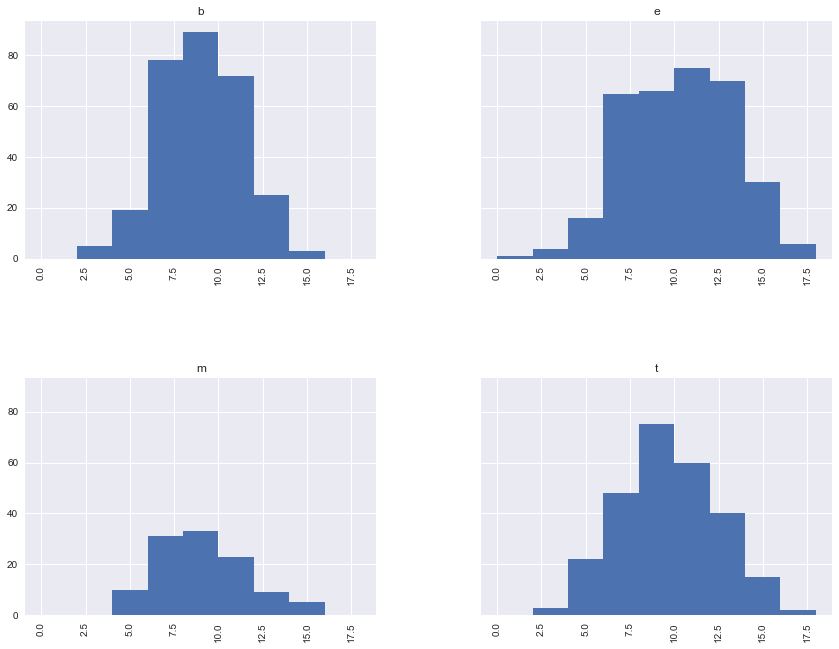

In [117]:
news.hist(column='TITLE_LENGTH', by='CATEGORY', bins=range(0, 20,2),figsize=(14,11), sharey=True)

**Words Representation**

The following code is show the most representative words per each <b>CATEGORY</b>. While the following code will plot the most representative words per each <b>CATEGORY</b>.

Corpus Size: 4580formed! Please wait ...

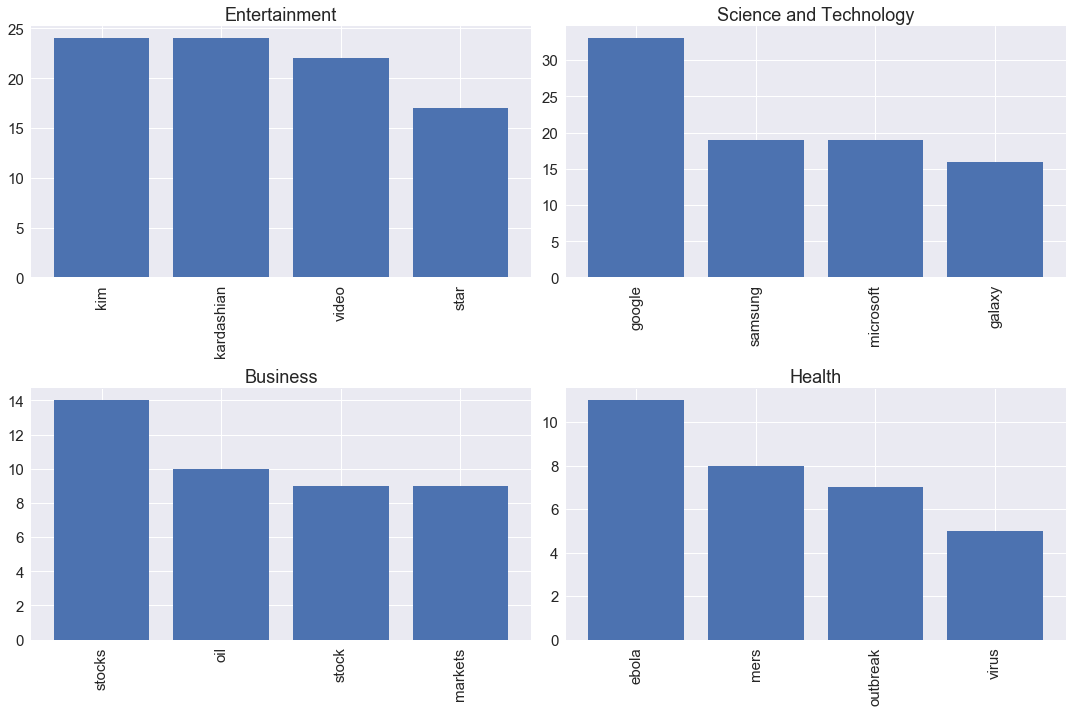

In [118]:
caption_0 = widgets.Label('Enter a number:')
text_0 = widgets.IntText(value=10)
button_0 = widgets.Button(description="Plot")
display(caption_0,text_0,button_0)

def histogram_label():
    n = text_0.value # Top n words
    corpus_size = 0
    i=1
    df = news[['TITLE','CATEGORY']]
    df['TITLE'] = news['TITLE'].apply(text_process).str.lower()
    categories = news.CATEGORY.unique()
    for category in categories:
            df_title=df.query('CATEGORY ==  @category')
            result =" ".join(df_title['TITLE'].values.tolist()).split(" ")
            r = pd.DataFrame(result, columns=['WORDS'])
            corpus_size = corpus_size + len(r['WORDS'].unique())
            Counter_=Counter(result).most_common(n)
            labels = [item[0] for item in Counter_]
            number = [item[1] for item in Counter_]
            nbars = len(Counter_)
            plt.subplot(2,2,i)
            plt.xticks(rotation=90,fontsize=15)
            plt.yticks(fontsize=15)
            plt.title(class_desc(category), fontsize=18)
            plt.bar(np.arange(nbars), number, tick_label=labels)
            i=i+1
    return corpus_size

def handle_submit(sender):
    t = ("Plot is being performed! Please wait ...")
    sys.stdout.write('\r'+t)
    plt.figure(figsize=(15,10))
    s = histogram_label()
    plt.tight_layout()
    sys.stdout.write('\r'+'Corpus Size: ' + str(s))
    sys.stdout.flush()
    
button_0.on_click(handle_submit)

# News Classification

The EDA section, mentioned above, has given some information about factors that could help perform classification of news stories to some level. In other words, the EDA has given some important information, but this could not be viewed enough to give more confident results of classifying news articles. For instance, the word <b>Google</b> is one of the most frequent words in the t-category (Technology and Science) articles, but this word could be used in business articles, and therefore, it cannot be generalized that every story that has the <b>Google</b> it leads to classify it as t-category.  In this section we are going to employ machine learning to help achieve the goal of this project.

According to EDA, it can be seen that the most significant feature is: <b>TITLE</b>. In the next code, we are going to create two objects X and y. X will be the 'TITLE' column of 'news' dataset. Moreover, as our case is supervised, y will be the class which is the <b>CATEGORY</b> column of our exploited dataset.

In [119]:
X = news.TITLE
y = news.CATEGORY

## Train Test Split

Following the best practices, we are going to split our data into training and testing data.

In [120]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(700,) (300,) (700,) (300,)


## Training Model

In this piece of work, we will implement different models and show the classification output according to each one. Then, the final result of prediction will be based on the result of all predictions as it will be presnted in the follwoing sections.

In order to make the procees of processing; vectorizer => transformer => classifier, easier, we will create a pipeline with the following steps: 
<ol>
<li>CountVectorizer()</li><li>TfidfTransformer()</li><li>Classifer; Suitable Supervised Model</li>

#### Training using Multinomial Naive Bayes

In [121]:
from sklearn.naive_bayes import MultinomialNB

# Initializing Pipline
pipelineNB = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts   ====  analyzer=normalize_text
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors
])

# Training the model
pipelineNB.fit(X_train, y_train)

# Saving training results using Pickle
with open('pipelineNB.pickle', 'wb') as handle:
    pickle.dump(pipelineNB, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Predictions
predictionsNB = pipelineNB.predict(X_test)

# Model Evaluation
print(classification_report(predictionsNB, y_test))

             precision    recall  f1-score   support

          b       0.70      0.75      0.72        85
          e       0.91      0.67      0.77       138
          m       0.06      1.00      0.11         2
          t       0.74      0.73      0.74        75

avg / total       0.80      0.71      0.74       300



In [122]:
# This is just for testing purposes :)
with open('pipelineNB.pickle', 'rb') as handle:
    NB = pickle.load(handle)
NB.predict(["See Mark Hamill prank 'Star Wars' superfans"])[0]

'e'

##### Cross Validation

In [123]:
%time scoresNB = cross_val_score(pipelineNB, X_train, y_train, cv = 5)
print("Cross-validation scores: {}".format(scoresNB))
print("Average cross-validation score: {:.2f} +/- {:.2f}".format(scoresNB.mean(), scoresNB.std()))
scoresNB = scoresNB.mean()

Wall time: 242 ms
Cross-validation scores: [ 0.67605634  0.68794326  0.66428571  0.69064748  0.75362319]
Average cross-validation score: 0.69 +/- 0.03


Wall time: 4.78 s


<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda_3\\lib\\site-packages\\matplotlib\\pyplot.py'>

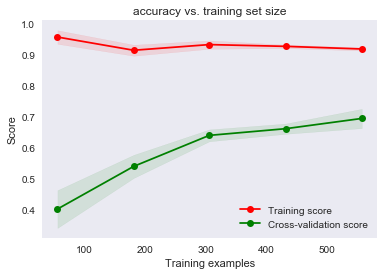

In [124]:
%time plot_learning_curve(pipelineNB, "accuracy vs. training set size", X_train, y_train, cv=5)

#### Training using Logistic Regression

In [125]:
from sklearn.linear_model import LogisticRegression

pipelineLOG = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts   === analyzer=normalize_text
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', LogisticRegression()),  # train on TF-IDF vectors
])
%time pipelineLOG.fit(X_train, y_train)

# Saving training results using Pickle
with open('pipelineLOG.pickle', 'wb') as handle:
    pickle.dump(pipelineLOG, handle, protocol=pickle.HIGHEST_PROTOCOL)

predictionsLOG = pipelineLOG.predict(X_test)

print(classification_report(predictionsLOG, y_test))

Wall time: 33 ms
             precision    recall  f1-score   support

          b       0.72      0.71      0.71        93
          e       0.90      0.63      0.74       144
          m       0.12      1.00      0.22         4
          t       0.64      0.80      0.71        59

avg / total       0.78      0.69      0.72       300



In [126]:
# This is just for testing purposes :)
with open('pipelineLOG.pickle', 'rb') as handle:
    LOG = pickle.load(handle)
LOG.predict(["See Mark Hamill prank 'Star Wars' superfans"])[0]

'e'

##### Cross Validation

In [127]:
%time scoresLOG = cross_val_score(pipelineLOG, X_train, y_train, cv = 5)
print("Cross-validation scores: {}".format(scoresLOG))
print("Average cross-validation score: {:.2f} +/- {:.2f}".format(scoresLOG.mean(), scoresLOG.std()))
scoresLOG = scoresLOG.mean()

Wall time: 166 ms
Cross-validation scores: [ 0.61971831  0.68794326  0.66428571  0.72661871  0.73913043]
Average cross-validation score: 0.69 +/- 0.04


Wall time: 5.28 s


<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda_3\\lib\\site-packages\\matplotlib\\pyplot.py'>

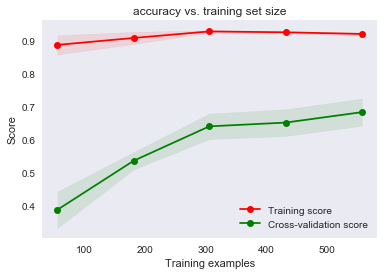

In [128]:
%time plot_learning_curve(pipelineLOG, "accuracy vs. training set size", X_train, y_train, cv=5)

#### Training using Decision Tree Classifier

In [129]:
from sklearn.tree import DecisionTreeClassifier

pipelineDT = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts   === analyzer=normalize_text
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', DecisionTreeClassifier(max_depth=10,random_state=0)),  # train on TF-IDF vectors
])

%time pipelineDT.fit(X_train, y_train)

# Saving training results using Pickle
with open('pipelineDT.pickle', 'wb') as handle:
    pickle.dump(pipelineDT, handle, protocol=pickle.HIGHEST_PROTOCOL)

predictionsDT = pipelineDT.predict(X_test)

print(classification_report(predictionsDT, y_test))

Wall time: 42 ms
             precision    recall  f1-score   support

          b       0.88      0.37      0.52       217
          e       0.33      0.60      0.42        55
          m       0.09      1.00      0.17         3
          t       0.27      0.80      0.40        25

avg / total       0.72      0.46      0.49       300



##### Cross Validation

In [130]:
%time scoresDT = cross_val_score(pipelineDT, X_train, y_train, cv = 5)
print("Cross-validation scores: {}".format(scoresDT))
print("Average cross-validation score: {:.2f} +/- {:.2f}".format(scoresDT.mean(), scoresDT.std()))
scoresDT = scoresDT.mean()

Wall time: 206 ms
Cross-validation scores: [ 0.3943662   0.4893617   0.47142857  0.47482014  0.46376812]
Average cross-validation score: 0.46 +/- 0.03


Wall time: 4.39 s


<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda_3\\lib\\site-packages\\matplotlib\\pyplot.py'>

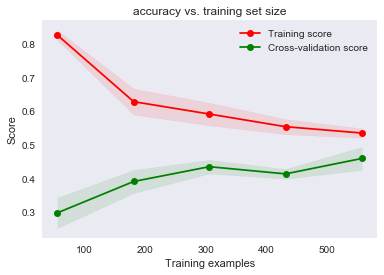

In [131]:
%time plot_learning_curve(pipelineDT, "accuracy vs. training set size", X_train, y_train, cv=5)

#### Training using Random Forest Classifier

In [132]:
from sklearn.ensemble import RandomForestClassifier

pipelineRF = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts   === analyzer=normalize_text
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', RandomForestClassifier(n_estimators=20)),  # train on TF-IDF vectors
])

%time pipelineRF.fit(X_train, y_train)

# Saving training results using Pickle
with open('pipelineRF.pickle', 'wb') as handle:
    pickle.dump(pipelineRF, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
predictionsRF = pipelineRF.predict(X_test)

print(classification_report(predictionsRF, y_test))

Wall time: 164 ms
             precision    recall  f1-score   support

          b       0.54      0.53      0.54        94
          e       0.76      0.50      0.61       153
          m       0.09      0.75      0.16         4
          t       0.39      0.59      0.47        49

avg / total       0.62      0.53      0.56       300



##### Cross Validation

In [133]:
%time scoresRF = cross_val_score(pipelineRF, X_train, y_train, cv = 5)
print("Cross-validation scores: {}".format(scoresRF))
print("Average cross-validation score: {:.2f} +/- {:.2f}".format(scoresRF.mean(), scoresRF.std()))
scoresRF = scoresRF.mean()

Wall time: 688 ms
Cross-validation scores: [ 0.53521127  0.58865248  0.57142857  0.5971223   0.55072464]
Average cross-validation score: 0.57 +/- 0.02


Wall time: 6.09 s


<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda_3\\lib\\site-packages\\matplotlib\\pyplot.py'>

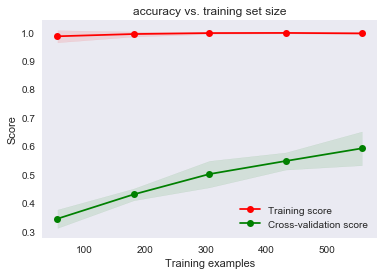

In [134]:
%time plot_learning_curve(pipelineRF, "accuracy vs. training set size", X_train, y_train, cv=5)

#### Training using K-Neighbors Classifier
For memory limitation errors, there was no chance to use KNN classifier.

In [35]:
# from sklearn.neighbors import KNeighborsClassifier

# pipelineKNN = Pipeline([
#     ('bow', CountVectorizer()),  # strings to token integer counts   === analyzer=normalize_text
#     ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
#     ('classifier', KNeighborsClassifier()),  # train on TF-IDF vectors
# ])

# %time pipelineKNN.fit(X_train, y_train)

# # Saving training results using Pickle
# with open('pipelineKNN.pickle', 'wb') as handle:
#     pickle.dump(pipelineKNN, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# predictionsKNN = pipelineKNN.predict(X_test)

# print(classification_report(predictionsKNN, y_test))

##### Cross Validation

In [36]:
# %time scoresKNN = cross_val_score(pipelineKNN, X_train, y_train, cv = 5)
# print("Cross-validation scores: {}".format(scoresKNN))
# print("Average cross-validation score: {:.2f} +/- {:.2f}".format(scoresKNN.mean(), scoresKNN.std()))
# scoresKNN = scoresKNN.mean()

In [37]:
# %time plot_learning_curve(pipelineKNN, "accuracy vs. training set size", X_train, y_train, cv=5)

#### Training using SVM

In [236]:
# from sklearn.svm import SVC
from sklearn.svm import LinearSVC


pipelineSV = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts   === analyzer=normalize_text
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    #('classifier', svm.LinearSVC()),  # train on TF-IDF vectors
    ('classifier', svm.SVC(probability=True)),  # train on TF-IDF vectors
])

%time pipelineSV.fit(X_train, y_train)

# Saving training results using Pickle
with open('pipelineSV.pickle', 'wb') as handle:
    pickle.dump(pipelineSV, handle, protocol=pickle.HIGHEST_PROTOCOL)

predictionsSV = pipelineSV.predict(X_test)

print(classification_report(predictionsSV, y_test))

Wall time: 365 ms
             precision    recall  f1-score   support

          b       0.00      0.00      0.00         0
          e       1.00      0.34      0.50       300
          m       0.00      0.00      0.00         0
          t       0.00      0.00      0.00         0

avg / total       1.00      0.34      0.50       300



In [237]:
# This is just for testing purposes :)
with open('pipelineSV.pickle', 'rb') as handle:
    SV = pickle.load(handle)
SV.predict(["See Mark Hamill prank 'Star Wars' superfans"])[0]

'e'

##### Cross Validation

In [238]:
%time scoresSV = cross_val_score(pipelineSV, X_train, y_train, cv = 5)
print("Cross-validation scores: {}".format(scoresSV))
print("Average cross-validation score: {:.2f} +/- {:.2f}".format(scoresSV.mean(), scoresSV.std()))
scoresSV = scoresSV.mean()

Wall time: 1.27 s
Cross-validation scores: [ 0.33098592  0.33333333  0.32857143  0.33093525  0.33333333]
Average cross-validation score: 0.33 +/- 0.00


Wall time: 35 s


<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda_3\\lib\\site-packages\\matplotlib\\pyplot.py'>

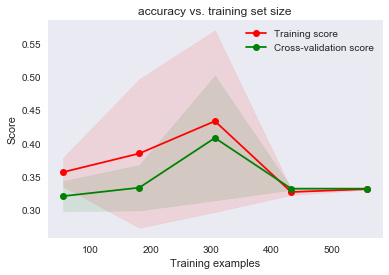

In [239]:
%time plot_learning_curve(pipelineSV, "accuracy vs. training set size", X_train, y_train, cv=5)

#### Training using Neural-Network

In [138]:
from sklearn.neural_network import MLPClassifier

# Initializing Pipline
pipelineMLP = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts   ====  analyzer=normalize_text
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MLPClassifier(hidden_layer_sizes=2)),  # train on TF-IDF vectors   # hidden_layer_sizes=2
])

# Training the model
%time pipelineMLP.fit(X_train, y_train)

# Saving training results using Pickle
with open('pipelineMLP.pickle', 'wb') as handle:
    pickle.dump(pipelineMLP, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Predictions
predictionsMLP = pipelineMLP.predict(X_test)

# Model Evaluation
print(classification_report(predictionsMLP, y_test))

Wall time: 908 ms
             precision    recall  f1-score   support

          b       0.59      0.72      0.65        75
          e       0.94      0.58      0.72       163
          m       0.00      0.00      0.00         0
          t       0.58      0.69      0.63        62

avg / total       0.78      0.64      0.68       300



##### Cross Validation

In [139]:
%time scoresMLP = cross_val_score(pipelineMLP, X_train, y_train, cv = 5)
print("Cross-validation scores: {}".format(scoresMLP))
print("Average cross-validation score: {:.2f} +/- {:.2f}".format(scoresMLP.mean(), scoresMLP.std()))
scoresMLP = scoresMLP.mean()

Wall time: 3.41 s
Cross-validation scores: [ 0.48591549  0.36170213  0.55        0.37410072  0.63043478]
Average cross-validation score: 0.48 +/- 0.10


In [55]:
# For resource limitations, this part could not work properly
# %time plot_learning_curve(pipelineMLP, "accuracy vs. training set size", X_train, y_train, cv=5)

# System Evaluation and Deployment
In this section we will create the <b>ensemble_predic</b> funtion. This function will take in a text, which is the headline of a news artice, then it gives back the category of the given article headline. The prediction works as follows. It predict the category of the given text employing different supervised learning models. As the label is discrete, then, we have employed different classifiers as shown in the <b>News Classification</b> section. The prediction result is based on the highest mean of each category group.

In [214]:
import lime
import sklearn
import numpy as np
import sklearn
import sklearn.ensemble
import sklearn.metrics
from __future__ import print_function
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
from sklearn.svm import LinearSVC


In [245]:
def ensemble_predic(p_title):
    
    
    results = pd.DataFrame({'model' : pd.Series(['NB', 'LOG','DT', 'RF', 'SV', 'MLP'], index=['1', '2', '3','4','5','6']),
                            'class' : pd.Series([read_from_pickle('pipelineNB').predict([p_title])[0], 
                                                 read_from_pickle('pipelineLOG').predict([p_title])[0], 
                                                 read_from_pickle('pipelineDT').predict([p_title])[0],
                                                 read_from_pickle('pipelineRF').predict([p_title])[0],
                                                 read_from_pickle('pipelineSV').predict([p_title])[0],
                                                 read_from_pickle('pipelineMLP').predict([p_title])[0]], index=['1', '2', '3','4','5','6']),
                           'percent' : pd.Series([scoresNB, 
                                                 scoresLOG, 
                                                 scoresDT,
                                                 scoresRF,
                                                 scoresSV,
                                                 scoresMLP], index=['1', '2', '3','4','5','6'])})

    errors_average = results['percent'].mean() - results['percent'].std()
   
   
    model=results[results.percent >= errors_average].groupby('model')['percent'].mean().idxmax()
    result=results[results.percent >= errors_average].groupby('class')['percent'].mean().idxmax()
    
    class_names = ['b','t','e','m']
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(p_title,read_from_pickle('pipeline'+model).predict_proba, num_features=4)
   
    exp.save_to_file('/tmp/oi.html')
    exp.show_in_notebook(text=True)
    
    
   
    
    print(results)
    
    
    return result

## Model Evaluation
In this sub-section we will evaluate our model using the Test set resulted from the split preocess. We will calculate the expected prediction using the <b>ensemble_predic</b> function, and compare the prediction results against the actual category of each story in the test set. Significantly, without a normalizing function; specifically removing stops words; the results seem to be better in terms of accuracy.

X_test_pred = X_test[0::].apply(ensemble_predic)

## Model Deployment
In this sub-section, we have built a simple user interface that accepts a text and gives back the most likely classification.

In [246]:
caption = widgets.Label('Enter an article here:')
text = widgets.Textarea()
button = widgets.Button(description="Classify")
display(caption,text,button)

def handle_submit(sender):
    message = text.value
    clear_output()
    print('Text: '+message)
    print('\n')
    print('Most likely prediction: ', class_desc(ensemble_predic(message)))
    print('\n-----------------------------------------------------------------------')
    print('b = business, t = science and technology, e = entertainment, m = health')
    
button.on_click(handle_submit)


'''
   Testing Examples:
    - Testing examples:
    - IBM sales has grown 33% in the last 5 years
    - Pearson shareholders reject chief executive's £1.5m pay package 
    - World Bank transfers $5.6 million to PA
    - Child’s Play Is Good for All of Us
    - Why Kids Shouldn’t Sit Still in Class
    - Why Deep Breathing May Keep Us Calm
    - In Rare Unity, Hospitals, Doctors and Insurers Criticize Health Bill
    - Scientists can now count birds from space
    - What to expect with the iPhone 8
    - See Mark Hamill prank 'Star Wars' superfans
    - Lyft and Waymo Reach Deal to Collaborate on Self-Driving Cars
'''

Text: Lyft and Waymo Reach Deal to Collaborate on Self-Driving Cars




  class model   percent
1     t    NB  0.694511
2     t   LOG  0.687539
3     b    DT  0.458749
4     b    RF  0.568628
5     e    SV  0.331432
6     t   MLP  0.480431
Most likely prediction:  Science and Technology

-----------------------------------------------------------------------
b = business, t = science and technology, e = entertainment, m = health


# Conclusion and Future Work
In this project, news classifiers has been developed. Some supervised learning machine learning models were employed in the prediction of the category of news story. As seen in the deployment section, each model could give different results from otherclassifiers, and so, the final result was calculated based on the highest mean of a ctegory result.

As seen in this piece of work, the data tested was for news stories witten in the English language. As a futeure work, we will re-train and test our model on articles in the Arabic language. An aggregator can also be built employing the desired classifier. This aggregator shall be enabled to collect news stories based on a specific category that is of an interest of a specific user.